In [102]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "http://financefunonfriday.com/wp-content/uploads/2017/04/eating-1024x701.jpg", width=1000, height=100)


# Coursera Capstone Project II - k-mean clustering of Hanover Venues 

## 1. Background


Suppose you are moving to a new city, like Hannover
You want to get an impression of what the individual districts are like
Especially if they have lots of restaurants to eat out or if its a rather quiet area.
Question that should be answered:
Is the district you are moving an Eat-In or an Eat-Out place?

## 2. Methods
Load the modules

In [92]:
import numpy as np # library for vectorized computation
import pandas as pd # library to process data as dataframes
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

from bs4 import BeautifulSoup
import requests # library to handle requests
import re

from geopy.geocoders import Nominatim
import folium

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

from sklearn.cluster import KMeans
from sklearn import preprocessing

Lets first collect the names of all districts from Wikipedia:

In [2]:
url = 'https://de.wikipedia.org/wiki/Liste_der_Stadtbezirke_und_Stadtteile_Hannovers'
source = requests.get(url).text
soup = BeautifulSoup(source)

table_data = soup.find('div', class_='mw-parser-output')
table = table_data.table.tbody

columns = ['Stadtbezirk', 'Stadtteil']
data = dict({key:[]*len(columns) for key in columns})


And put them in a pandas Dataframe. Each "Stadtbezirk" has multiple "Stadtteile".

In [3]:
for row in table.find_all('tr'):
    for i,column in zip(row.find_all('td'),columns):
        i = i.text
        i = i.replace('\n', '')
        print(i)
        data[column].append(i)
df = pd.DataFrame.from_dict(data=data)[columns]
print(df.shape)
df.head()
# split and make it into all the smaller stadtteile


1. Mitte
01 Mitte, 02 Calenberger Neustadt, 08 Zoo, 09 Oststadt
2. Vahrenwald-List
10 List, 11 Vahrenwald
3. Bothfeld-Vahrenheide
12 Vahrenheide, 21 Sahlkamp, 22 Bothfeld, 24 Lahe, 48 Isernhagen-Süd
4. Buchholz-Kleefeld
25 Groß-Buchholz, 26 Kleefeld, 27 Heideviertel
5. Misburg-Anderten
50 Misburg-Nord, 51 Misburg-Süd, 52 Anderten
6. Kirchrode-Bemerode-Wülferode
28 Kirchrode, 47 Bemerode, 53 Wülferode
7. Südstadt-Bult
04 Südstadt, 07 Bult
8. Döhren-Wülfel
05 Waldhausen, 06 Waldheim, 29 Döhren, 30 Seelhorst, 31 Wülfel, 32 Mittelfeld
9. Ricklingen
39 Bornum, 40 Ricklingen, 41 Oberricklingen, 42 Mühlenberg, 43 Wettbergen
10. Linden-Limmer
33 Linden-Nord, 34 Linden-Mitte, 35 Linden-Süd, 36 Limmer
11. Ahlem-Badenstedt-Davenstedt
37 Davenstedt, 38 Badenstedt, 44 Ahlem
12. Herrenhausen-Stöcken
14 Herrenhausen, 15 Burg, 16 Leinhausen, 17 Ledeburg, 18 Stöcken, 19 Marienwerder, 20 Nordhafen
13. Nord
03 Nordstadt, 13 Hainholz, 45 Vinnhorst, 49 Brink-Hafen
(13, 2)


,Stadtbezirk,Stadtteil
0,1. Mitte,"01 Mitte, 02 Calenberger Neustadt, 08 Zoo, 09 ..."
1,2. Vahrenwald-List,"10 List, 11 Vahrenwald"
2,3. Bothfeld-Vahrenheide,"12 Vahrenheide, 21 Sahlkamp, 22 Bothfeld, 24 L..."
3,4. Buchholz-Kleefeld,"25 Groß-Buchholz, 26 Kleefeld, 27 Heideviertel"
4,5. Misburg-Anderten,"50 Misburg-Nord, 51 Misburg-Süd, 52 Anderten"


In [112]:
# Now you need your foursquare Api to make the requests
CLIENT_ID = 'XXX' # your Foursquare ID
CLIENT_SECRET = 'XXX' # your Foursquare Secret
VERSION = '20210201' # Foursquare API version

# magic numbers thresholds for data to scrape
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 2000 # define radius


Run the block below to request nearby venues from each district and put into a dataframe

In [147]:

n_districts = len(data['Stadtbezirk'])
nearby_venues_filtered_agg = pd.DataFrame()

for n in range(n_districts):
    stadtteile = data['Stadtteil'][n].split(',')
    stadtbezirk = data['Stadtbezirk'][n].split(' ')[1]
#    print(stadtbezirk)
    for l in range(len(stadtteile)):
        stadtteil = stadtteile[l]
        stadtteil = stadtteil.lstrip()
        pattern = r'[0-9]'
        
        # remove digits
        stadtteil = re.sub(pattern, '', stadtteil)
        stadtteil = stadtteil[1:]
#        print(stadtteil)

        geolocator = Nominatim(user_agent="dis-app")
        city = 'Hannover'
        address = '{}-{}'.format(city,stadtteil)

        location = geolocator.geocode(address)

        latitude = location.latitude
        longitude = location.longitude 
 #       location_tuple = (longitude, latitude)
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            latitude, 
            longitude, 
            radius, 
            LIMIT)
        results = requests.get(url).json()
        venues = results['response']['groups'][0]['items']
        nearby_venues = json_normalize(venues) # flatten JSON
        nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)
        nearby_venues
        
        nearby_venues.head()
        filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 
                          'venue.location.lng', 'venue.id']
        nearby_venues_filtered = nearby_venues.loc[:, filtered_columns]
        # filter the category for each row
        #nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)
        # clean columns
        nearby_venues_filtered.columns = [col.split(".")[-1] for col in nearby_venues_filtered.columns]
        nearby_venues_filtered['Stadtbezirk'] = stadtbezirk
        nearby_venues_filtered['Stadtteil'] = stadtteil

        nearby_venues_filtered_agg = nearby_venues_filtered_agg.append(nearby_venues_filtered,ignore_index=True)


<ipython-input-147-dee2ce03af90>:37: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  nearby_venues = json_normalize(venues) # flatten JSON


In [153]:
nearby_venues_filtered_agg.head()

,name,categories,lat,lng,id,Stadtbezirk,Stadtteil
0,Al-Dar,Syrian Restaurant,52.375288,9.746800,4b79a35af964a52060072fe3,Mitte,Mitte
1,Aspera,Turkish Restaurant,52.376324,9.748424,5308f3ff11d2fafb95ea29ef,Mitte,Mitte
2,Sushi-Do,Sushi Restaurant,52.374704,9.745104,4b7fe29af964a520734230e3,Mitte,Mitte
3,wok n' joy,Vietnamese Restaurant,52.376928,9.751786,57c02040cd10129f93469f9c,Mitte,Mitte
4,Tomo Sushi,Sushi Restaurant,52.378944,9.750229,4d9d97b05c33a35d372404a1,Mitte,Mitte


In [159]:
# Save to file
nearby_venues_filtered_agg.to_csv('nearby_venues.csv')    



In [93]:
## Create the map
geolocator = Nominatim(user_agent="dis-app")

hannover_center = 'Hannover Mitte'
hannover_center = geolocator.geocode(hannover_center)
hannover_center_la = hannover_center.latitude
hannover_center_lo = hannover_center.longitude
hannover_center = (hannover_center_la, hannover_center_lo)

map_hannover = folium.Map(location=hannover_center, zoom_start=13)
#folium.Circle([latitude, longitude], radius=500, color='red', fill=False).add_to(map_hannover)

map_hannover

In [94]:
## more than 500 requests, Quota exceeded
# not needed for our analysis, so leave out
# def get_likes(venue_id):
#     venue_url = 'https://api.foursquare.com/v2/venues/{}/likes?client_id={}&client_secret={}&v={}'.format(venue_id,
#                                                                                                       CLIENT_ID,
#                                                                                                       CLIENT_SECRET,
#                                                                                                       VERSION)
#     result = requests.get(venue_url).json()
#     likes = result['response']['likes']['count']
        
#     return likes

# nearby_venues['likes'] = nearby_venues.apply(lambda row: get_likes(row['id']), axis=1)



You can start from here, if you have the nearby_venues.csv dataframe.
Tasks:
* get all nearby venues and plot with name on map
* collect in one dataframe
* categorize
* and then determine frequency of which in each district

In [29]:


nearby_venues = pd.read_csv('nearby_venues.csv')
len(nearby_venues)


1315

Pre-categorize the different venues, since there are too many different categories. Leave out the "Other" class.

In [30]:
def is_category(cat):
    restaurant_keys = ['restaurant', 'pizza', 'burger', 'chicken', 'steakhouse', 'taverna', 'bistro']
    sports_keys = ['gym', 'fitness', 'sports', 'soccer', 'tennis', 'golf', 'pool']
    entertainment_keys = ['theater', 'art', 'opera', 'museum', 'arts', 'movie']
    nightlife_keys = ['bar', 'pub', 'nightclub', 'wine', 'beer']
    grocery_keys = ['supermarket', 'grocery', 'food', 'market']
    for restaurant_key in restaurant_keys:
        if restaurant_key in cat.lower():
            category = 'Restaurant'
            break
        else:
            category = 'Other'
    for sports_key in sports_keys:
        if sports_key in cat.lower():
            category = 'Sports'
            break
    for entertainment_key in entertainment_keys:
        if entertainment_key in cat.lower():
            category = 'Entertainment'
            break            
    for nightlife_key in nightlife_keys:
        if nightlife_key in cat.lower():
            category = 'Nightlife'
            break                
    for grocery_key in grocery_keys:
        if grocery_key in cat.lower():
            category = 'Grocery'
            break                            
            
    return category


# classified as 
nearby_venues['classified'] = nearby_venues.apply(lambda row: is_category(row['categories']), axis=1)

# remove rest 
nearby_venues = nearby_venues.loc[nearby_venues['classified']!='Other']
print(len(nearby_venues))

662


In [31]:
nearby_venues['classified'].value_counts()

labels = nearby_venues['classified'].unique()
print(labels)
colors_array = cm.jet(np.linspace(0, 1, len(labels)))
rainbow = [colors.rgb2hex(i) for i in colors_array]


['Restaurant' 'Entertainment' 'Nightlife' 'Grocery' 'Sports']


In [95]:
# nearby_except = nearby_venues.loc[nearby_venues['classified']!='Other']
# len(nearby_except)
# nearby_except['categories'].value_counts()

Encode the classified to assign the colors

In [96]:

labelencoder = preprocessing.LabelEncoder()
nearby_venues['cat_code'] = labelencoder.fit_transform(nearby_venues['classified'])

nearby_venues.head()

,Unnamed: 0,name,categories,lat,lng,id,Stadtbezirk,Stadtteil,classified,cat_code
0,0,Al-Dar,Syrian Restaurant,52.375288,9.746800,4b79a35af964a52060072fe3,Mitte,Mitte,Restaurant,3
1,1,Aspera,Turkish Restaurant,52.376324,9.748424,5308f3ff11d2fafb95ea29ef,Mitte,Mitte,Restaurant,3
2,2,Sushi-Do,Sushi Restaurant,52.374704,9.745104,4b7fe29af964a520734230e3,Mitte,Mitte,Restaurant,3
3,3,wok n' joy,Vietnamese Restaurant,52.376928,9.751786,57c02040cd10129f93469f9c,Mitte,Mitte,Restaurant,3
4,4,Tomo Sushi,Sushi Restaurant,52.378944,9.750229,4d9d97b05c33a35d372404a1,Mitte,Mitte,Restaurant,3


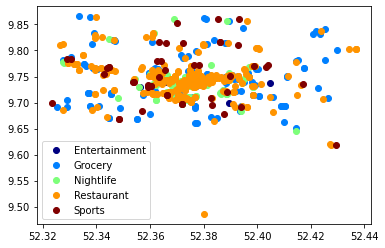

In [44]:
# First look athe the distribution of venues. Many Restaurants in the city center.

#nearby_venues['cat_code'].unique()
for icat in range(len(nearby_venues['cat_code'].unique())):
    single_cat = nearby_venues.loc[nearby_venues['cat_code']==icat]
    plt.scatter(single_cat['lat'],single_cat['lng'],c=rainbow[icat], cmap='jet', label=labelencoder.classes_[icat])
plt.legend()

One hot encode the different categories and group by "Stadtteil".
Find out what is the average "class" in each Stadtteil. (Some have only 1 or 2 venues so that it is not very representative.)

In [105]:

hannover_onehot = pd.get_dummies(nearby_venues[['classified']], prefix="", prefix_sep="")
# hannover_onehot['Stadtbezirk'] = nearby_venues['Stadtbezirk'] 
# hannover_groupedby = hannover_onehot.groupby('Stadtbezirk').mean().reset_index()

hannover_onehot['Stadtteil'] = nearby_venues['Stadtteil'] 
hannover_groupedby = hannover_onehot.groupby('Stadtteil').mean().reset_index()


Determine the top 3 Stadtteile with the highest value in the respective class

In [97]:
print('Sort by Nightlife')
print(hannover_groupedby.sort_values(by=['Nightlife'],ascending=False)[0:3])
# which distric has the highest restaurant density
print('##################')

print('Sort by Entertainment')
print(hannover_groupedby.sort_values(by=['Entertainment'],ascending=False)[0:3])
print('##################')

print('Sort by Restaurant')
print(hannover_groupedby.sort_values(by=['Restaurant'],ascending=False)[0:3])
print('##################')

print('Sort by Sports')
print(hannover_groupedby.sort_values(by=['Sports'],ascending=False)[0:3])


Sort by Nightlife
      Stadtteil  Entertainment   Grocery  Nightlife  Restaurant    Sports
31    Nordhafen            0.0  0.000000   1.000000    0.000000  0.000000
32    Nordstadt            0.0  0.250000   0.400000    0.300000  0.050000
23  Linden-Nord            0.0  0.139535   0.325581    0.488372  0.046512
##################
Sort by Entertainment
   Stadtteil  Entertainment   Grocery  Nightlife  Restaurant  Sports
28     Mitte       0.127273  0.090909   0.163636    0.618182     0.0
12  Hainholz       0.100000  0.300000   0.000000    0.500000     0.1
34  Oststadt       0.090909  0.109091   0.163636    0.636364     0.0
##################
Sort by Restaurant
         Stadtteil  Entertainment  Grocery  Nightlife  Restaurant  Sports
30      Mühlenberg            0.0      0.0        0.0         1.0     0.0
37       Seelhorst            0.0      0.0        0.0         1.0     0.0
15  Isernhagen-Süd            0.0      0.2        0.0         0.8     0.0
##################
Sort by Sports
 

Now do a K-means clustering for the one hot encoded dataframe to find similar Stadtteile. Drop the name before. 
Since we have not too many venues in some districts, we go for differentiating between a 
"Eat-In" or "Eat-Out" district.

In [106]:
kclusters = 2
hannover_groupedby_clustering = hannover_groupedby.drop(columns=['Stadtteil'])

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(hannover_groupedby_clustering)

# check cluster labels generated for each row in the dataframe

colors_array = cm.rainbow(np.linspace(0, 1, kclusters))
rainbow2 = [colors.rgb2hex(i) for i in colors_array]


Gather the stats from the k-means and the number of venues in each district in a new dataframe.

In [108]:
stadtteil_stats = nearby_venues.groupby('Stadtteil').mean().reset_index()

# add number of venues
stadtteil_stats['n_venue'] = 0

for i,istat in enumerate(stadtteil_stats['Stadtteil']):
    n_venue = len(nearby_venues.loc[nearby_venues['Stadtteil']==istat])
#    print(i,istat,n_venue)
    stadtteil_stats['n_venue'][i] = n_venue
    



stadtteil_stats.drop(columns=['Unnamed: 0'], inplace=True)
# add cluster labels

stadtteil_stats['k_means'] = kmeans.labels_



stadtteil_stats['Entertainment'] = hannover_groupedby['Entertainment']
stadtteil_stats['Grocery'] = hannover_groupedby['Grocery']
stadtteil_stats['Nightlife'] = hannover_groupedby['Nightlife']
stadtteil_stats['Restaurant'] = hannover_groupedby['Restaurant']
stadtteil_stats['Sports'] = hannover_groupedby['Sports']
stadtteil_stats.head()

<ipython-input-108-16b78ac6b95b>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stadtteil_stats['n_venue'][i] = n_venue


,Stadtteil,lat,lng,cat_code,n_venue,k_means,Entertainment,Grocery,Nightlife,Restaurant,Sports
0,Ahlem,52.382215,9.667785,1.833333,6,0,0.0,0.666667,0.0,0.166667,0.166667
1,Badenstedt,52.349309,9.669468,2.000000,3,0,0.0,0.666667,0.0,0.000000,0.333333
2,Bemerode,52.343772,9.823609,1.900000,10,0,0.0,0.500000,0.1,0.400000,0.000000
3,Bornum,52.349592,9.675932,2.333333,6,0,0.0,0.500000,0.0,0.166667,0.333333
4,Bothfeld,52.425450,9.781761,1.000000,1,0,0.0,1.000000,0.0,0.000000,0.000000



# 3. Results and Analysis

You can click on the circles for the districts or the dots for the individual venues.

In [111]:
### Aggregate the above 
map_hannover = folium.Map(location=hannover_center, zoom_start=11)

for lat, lon, poi, cluster, numbers,st_et,st_gr,st_nl,st_re,st_sp in zip(stadtteil_stats['lat'],
                                                                         stadtteil_stats['lng'],
                                                                         stadtteil_stats['Stadtteil'],
                                                                         stadtteil_stats['k_means'],
                                                                         stadtteil_stats['n_venue'],
                                                                         stadtteil_stats['Entertainment'],
                                                                         stadtteil_stats['Grocery'],
                                                                         stadtteil_stats['Nightlife'],
                                                                         stadtteil_stats['Restaurant'],
                                                                         stadtteil_stats['Sports']):
    label = folium.Popup('{0}\n Entertainment={1:.2f} % \n Grocery={2:.2f} % \n Nightlife={3:.2f} % \n Restaurant={4:.2f} % \n Sports={5:.2f} % '.format(poi, st_et,st_gr,st_nl,st_re,st_sp), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=50*np.log10(numbers),
        popup=label,
        color=rainbow2[cluster],
        fill=True,
        fill_color=rainbow2[cluster],
        fill_opacity=0.1).add_to(map_hannover)
    
for lat, lon, poi,classified,ccode in zip(nearby_venues['lat'],
                         nearby_venues['lng'],
                         nearby_venues['name'],
                         nearby_venues['classified'],
                         nearby_venues['cat_code']):
    label = folium.Popup('{0}, {1}'.format(poi,classified), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=1,
        popup=label,
        color=rainbow[ccode],
        fill=True,
        fill_color='black',
        fill_opacity=0.7).add_to(map_hannover)
map_hannover

# 4. Discussion and Conclusion

Eat-in or Out is determined by the restaurant and supermarket density in each district.

With this map we were able to find similar clusters. 
Click on the circles to see the stats pf each district.

In the city center, we can find, as to be expected, many restaurants (Red clusters).
The second biggest contributor are the supermarkets, which tend to take over in the outer regions (purple clusters)

The sports, nightlife and entertainment clusters were not taken into account, since they did not successfully separate that well. There were generally too little similar venues within each discrict, to reliably capture more different clusterss.


Thanks for checking out my notebook. I am really glad for helpful feedback or advise. It would be nice to compare with more classes and also take into account the venues classified as "Other". For sure there is many more interesting things to investigate about this kind of data. 
But this quick k-means clustering exercise was just to get a result for the Capstone project, which was part of the 10-course programme of the IBM Data Science professional certificate from coursera. 

